<a href="https://colab.research.google.com/github/jjgranadat/Semillero_SOFA/blob/C%C3%A9sar/knn_svm_kmeans_16qam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from scipy.io import loadmat

# Globales

In [2]:
def downloadFile(link):
    # Nombre del archivo
    file = link.split('/')[-1]
    
    # Descarga el archivo si no se ha hecho aún
    !if ! [[ -f "$file" ]]; then wget $link; fi;
    
    # Carga los datos
    data = loadmat(file)
    
    return data

# Datos experimentales

In [3]:
mod_dict = {0: -3+3j, #0000
            1: -3+1j, #0001
            2: -3-3j, #0010
            3: -3-1j, #0011
            4: -1+3j, #0100
            5: -1+1j, #0101
            6: -1-3j, #0110
            7: -1-1j, #0111
            8:  3+3j, #1000
            9:  3+1j, #1001
            10: 3-3j, #1010
            11: 3-1j, #1011
            12: 1+3j, #1100
            13: 1+1j, #1101
            14: 1-3j, #1110
            15: 1-1j} #1111


In [12]:
# Enlace del archivo (raw)
link_rx = "https://github.com/jjgranadat/Semillero_SOFA/raw/main/16QAM_3x16GBd_consY250km_00010.mat"
link_tx = "https://github.com/jjgranadat/Semillero_SOFA/raw/main/2x16QAM_16GBd.mat"

X_ch = downloadFile(link_rx)
# print(X_ch.keys())
X_ch = X_ch.get("const_Y").flatten()
# X_ch = X_ch*5.5

X_tx = downloadFile(link_tx)
# print(X_tx.keys())
X_tx = X_tx.get("Constellation").flatten()[0][1]
# X_tx = X_tx*5.5

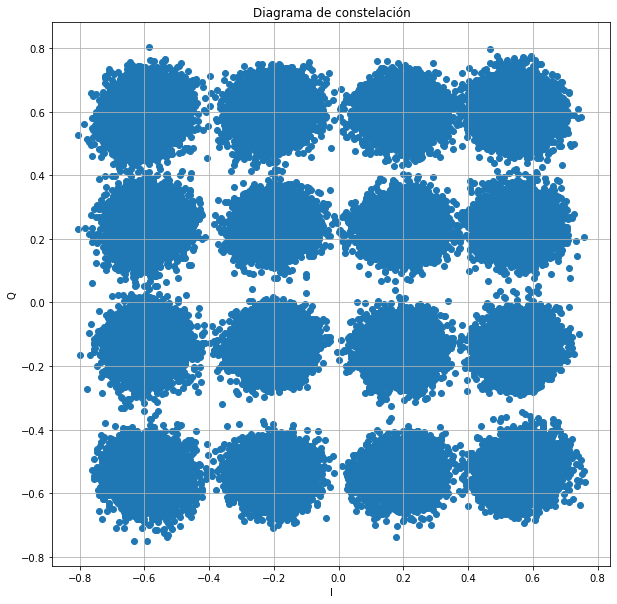

In [13]:
Xr_ch = X_ch.real
Xi_ch = X_ch.imag

plt.figure(figsize = (10, 10))
plt.scatter(Xr_ch, Xi_ch)

# for symbol in np.unique(sym_tx):
#     ix = np.where(sym_tx == symbol)
#     plt.scatter(Xr_ch[ix], Xi_ch[ix], label = symbol, s = 100)

plt.title("Diagrama de constelación")
plt.xlabel("I")
plt.ylabel("Q")
plt.grid(True)
# plt.legend()
plt.show()

# Demodulación tradicional

In [14]:
def demodulate(X_rx, mod_dict):
    demodulated = []
    # Diccionario para demodular
    demod_dict = dict(zip(mod_dict.values(), mod_dict.keys()))
    for x in X_rx:
        # Distancia a cada centroide
        dist = np.abs(np.array(list(mod_dict.values())) - x)
        # Índice del valor mínimo de distancia
        index = list(dist).index(np.min(dist))
        # Centroide más cercano al símbolo
        demodulated.append(index)
    return np.array(demodulated)

# Demodulación usando KNN

In [16]:
def demodulate_knn(X_rx, sym_tx, k):
    X = np.array([X_rx.real, X_rx.imag]).T
    y = sym_tx
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    
    # Número de vecinos
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, y_train)
    return model.predict(X)

# Demodulación usando SVM

In [17]:
def demodulate_svm(X_rx, sym_tx, C, gamma):
    X = np.array([X_rx.real, X_rx.imag]).T
    y = sym_tx
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    model = SVC(C = C, gamma = gamma)
    model.fit(X_train, y_train)
    return model.predict(X)

# Demodulación usando K-means

In [18]:
def demodulate_kmeans(X_rx, mod_dict):
    X = list(zip(X_rx.real, X_rx.imag))
    A_mc = [(x.real, x.imag) for x in list(mod_dict.values())]
    model = KMeans(n_clusters = 16, n_init = 1, init = np.array(A_mc))
    model.fit(X)

    return model.predict(X)

# Encontrar los mejores parámetros para los algoritmos

In [19]:
def find_best_params(estimator, param_grid, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    grid = GridSearchCV(estimator(), param_grid, verbose = 0)
    
    grid.fit(X_train, y_train)
    
    return grid.best_params_

# Medidas de error BER y SER

In [20]:
def SymbolErrorRate(sym_rx, sym_tx):
    error = 0
    for i in range(len(sym_tx)):
        if sym_rx[i] != sym_tx[i]:
            error += 1
    SER = error / len(sym_tx)
    return SER, error

def BitErrorRate(sym_rx, sym_tx):
    # Se transforman los símbolos a binario
    sym_rx_str = ''.join([f"{sym:04b}" for sym in sym_rx])
    sym_tx_str = ''.join([f"{sym:04b}" for sym in sym_tx])

    error = sum(sym_rx_str[i] != sym_tx_str[i] for i in range(len(sym_rx_str)))
    BER = error / len(sym_rx_str)
    return BER, error

In [21]:
X = X_ch.T
y = demodulate(X_tx.T, mod_dict)
kmeans = demodulate_kmeans(X, mod_dict)
trad = demodulate(X, mod_dict)

# Probar la correlación con los datos sin demodular
# Probar girando 90° la constelación recibida

[ 1937 68513]
El corrimiento necesario para corregir la señal transmitida es: [ 1937 68513]
[ 1  9  8  5  1  8 11  2 14  2  6 11  2 13  9  2 10 12  2 15]
[15 13  5  5  5 15  5 13  5 15  7 13  7 13 15  5 13 15 15 15]


(0.9363058495002939, 101930)

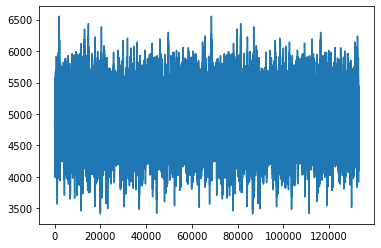

In [22]:
corr = np.correlate(y, kmeans[:100])
shifting = np.where(corr == np.max(corr))[0]
print(shifting)
print(f"El corrimiento necesario para corregir la señal transmitida es: {shifting}")
plt.plot(corr)

rolled_trad = np.roll(y, -shifting)[:len(kmeans)]

print(rolled_trad[:20])
print(trad[:20])

SymbolErrorRate(kmeans, rolled_trad)

In [ ]:
# Isabella
x = demodulate(X_tx.T, mod_dict)
y = kmeans[:int(len(kmeans)*0.2)]
correlacion = []
for i in range(len(x) - len(y) + 1):
    dif=np.dot(x[i:i+40], y[:40])
    correlacion.append(dif)
    if max(correlacion)==dif:
        print("inicio de trama en ", i, x[i], y[0], x[i+1], y[1])
print(correlacion)
print(max(correlacion))



inicio de trama en  0 0 14 10 9
inicio de trama en  1 10 14 2 9
inicio de trama en  82 0 14 10 9
inicio de trama en  84 8 14 0 9
inicio de trama en  1359 8 14 2 9
inicio de trama en  1371 10 14 0 9
inicio de trama en  1373 10 14 10 9
inicio de trama en  1976 10 14 8 9
inicio de trama en  1989 0 14 10 9
inicio de trama en  1997 8 14 8 9
inicio de trama en  68573 8 14 8 9
[1626, 1862, 1628, 1514, 1604, 1532, 1722, 1590, 1692, 1286, 1492, 1720, 1486, 1594, 1502, 1568, 1528, 1448, 1612, 1324, 1558, 1640, 1354, 1636, 1542, 1502, 1402, 1446, 1330, 1378, 1274, 1442, 1210, 1336, 1146, 1190, 1114, 1422, 1184, 1176, 1098, 1172, 1174, 1344, 1122, 1124, 1086, 1248, 1084, 1140, 1212, 922, 1326, 1298, 1056, 1208, 1068, 1250, 974, 1270, 1146, 1242, 1368, 1572, 1384, 1278, 1556, 1582, 1450, 1496, 1718, 1590, 1514, 1730, 1436, 1448, 1544, 1502, 1634, 1486, 1840, 1678, 1890, 1718, 2148, 1778, 1982, 1822, 1980, 1672, 1896, 1808, 1782, 1800, 1736, 1662, 1672, 1822, 1828, 1628, 1742, 1566, 1542, 1756, 1636